In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

## Load simulation data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'neuronal_model_491766131_Loc5')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
print(inference_list)

STATS = np.load(STATS_PATH)
summ_stats = STATS['x']
labels = STATS['y']
df_la = pd.DataFrame(labels, columns=inference_list)
has_yshift = 'y' in inference_list and STATS['ys'].size != 0
if has_yshift:
    ys_idx = inference_list.index('y')
    labels[:,ys_idx] = STATS['ys']
    df_la.sort_values(by='y',inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

['y', 'd', 'theta', 'h', 'phi']


,y,d,theta,h,phi
3277,-169.739982,93.339056,-0.052938,0.694601,1.584082
4081,-164.027871,75.893860,0.461758,0.397058,-2.554635
2770,-163.141283,87.414150,-0.105441,0.393111,-2.591868
2313,-157.627846,85.990904,-0.137737,0.428419,-3.018860
1083,-153.776923,97.243746,-0.584433,0.293957,1.505519
...,...,...,...,...,...
2986,161.672698,110.562837,-0.086152,-0.482508,2.358955
3401,168.648429,102.353980,-0.051306,-0.683057,-1.530028
5071,172.344766,104.757451,0.010990,-0.470862,3.086643
4640,178.894697,84.087937,0.034830,-0.402348,-3.121864


### Normalizing labels

#### Set bounds for y shift

In [3]:
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])
print(json.dumps(ranges))

if has_yshift:
    ranges['y'] = [-150, 150]
    df_la_idx = df_la[df_la['y'].between(*ranges['y'])].index.values
    labels = labels[df_la_idx,:]
    summ_stats = summ_stats[df_la_idx,:]
    with pd.option_context('display.max_rows',10):
        display(df_la.loc[df_la_idx])

{"x": [-50, 50], "y": [-1400, 1400], "z": [20.0, 200.0], "alpha": [0, 3.141592653589793], "h": [-1.0, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [20.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "r_s": [5.0, 12.0], "l_t": [20.0, 800.0], "r_t": [0.25, 0.8], "r_d": [0.15, 0.45], "r_tu": [0.15, 0.45], "l_d": [100.0, 300.0], "r_a": [0.15, 0.45]}


,y,d,theta,h,phi
5520,-149.920048,188.699947,0.019839,0.621961,-1.349307
806,-149.607940,114.961005,-0.093768,0.650776,1.441907
393,-148.965765,151.319380,-0.030395,0.006708,-0.391993
2429,-148.642802,124.415502,-0.164854,0.576268,-2.234539
3186,-147.584465,127.537886,-0.162821,-0.096610,-0.374134
...,...,...,...,...,...
3948,145.011054,142.773408,0.054445,-0.235360,-1.574611
3658,145.287421,172.242130,-0.133900,-0.647184,1.240667
3068,145.425366,122.165681,-0.185177,-0.975850,1.453407
696,146.242219,133.143234,0.207968,-0.916416,1.528273


#### Normalization

In [4]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(inference_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=inference_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,y,d,theta,h,phi
0,-0.999467,0.874444,0.018945,0.621961,-0.429498
1,-0.997386,0.055122,-0.089542,0.650776,0.458973
2,-0.993105,0.459104,-0.029025,0.006708,-0.124775
3,-0.990952,0.160172,-0.157424,0.576268,-0.711276
4,-0.983896,0.194865,-0.155483,-0.096610,-0.119091
...,...,...,...,...,...
5926,0.966740,0.364149,0.051991,-0.235360,-0.501214
5927,0.968583,0.691579,-0.127865,-0.647184,0.394917
5928,0.969502,0.135174,-0.176831,-0.975850,0.462634
5929,0.974948,0.257147,0.198595,-0.916416,0.486464


## Build model

In [5]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

isTrain = False
model_name = 'FCN_batch256.pth'
MODEL_PATH = os.path.join(TRIAL_PATH,model_name)

model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=labels.shape[1])

## Train model

In [6]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=256, shuffle=True)
if isTrain:
    history = train_regression(model, train_loader, test_loader, epochs=100, learning_rate=0.001, decay_rate=0.98)
    model.eval()
    torch.save(model.state_dict(), MODEL_PATH)

In [7]:
if isTrain:
    plt.figure()
    plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
    plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()

## Evaluate model

In [8]:
if not isTrain:
    model.load_state_dict(torch.load(MODEL_PATH))

In [9]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device("cpu")
model.eval()

y = []
output = []
for X, Y in test_loader:
    y.append(Y.to("cpu").detach().numpy())
    output.append(model(X.to(device)).to("cpu").detach().numpy())
y = np.concatenate(y, axis=0)
output = np.concatenate(output, axis=0)

# print("R2: {}".format(r2_score(y, output)))
for i, p in enumerate(inference_list):
    if has_yshift and i == ys_idx:
        p = 'y-shift'
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(y[:,i], output[:,i])))

# back to original scale
for i, lb in enumerate(inference_list):
    y[:,i] = org_scale(y[:,i], ranges[lb])
    output[:,i] = org_scale(output[:,i], ranges[lb])

df_la = pd.DataFrame(y, columns=inference_list).sort_values(by='y')
display(df_la)

R2 Score y-shift:   0.808
R2 Score d:         0.849
R2 Score theta:     0.660
R2 Score h:         0.933
R2 Score phi:       0.482


,y,d,theta,h,phi
209,-145.810364,139.781143,0.178446,0.881205,1.612766
1285,-145.629303,110.225540,-0.038269,0.190943,1.909712
51,-144.791107,182.225510,-0.108833,0.146580,1.705244
288,-140.558167,115.849113,0.247922,0.069969,0.538267
1404,-139.447342,131.250214,-0.551580,-0.074642,0.801230
...,...,...,...,...,...
1351,140.327087,159.448868,0.800000,-0.566046,-1.656499
1175,143.843048,107.135269,0.233706,0.186893,-1.113536
901,144.542633,139.130920,0.211264,-0.591354,2.993350
168,145.425354,122.165688,-0.185177,-0.975850,1.453407


Stylized Cell Testing Data: Ground Truth VS Predicted


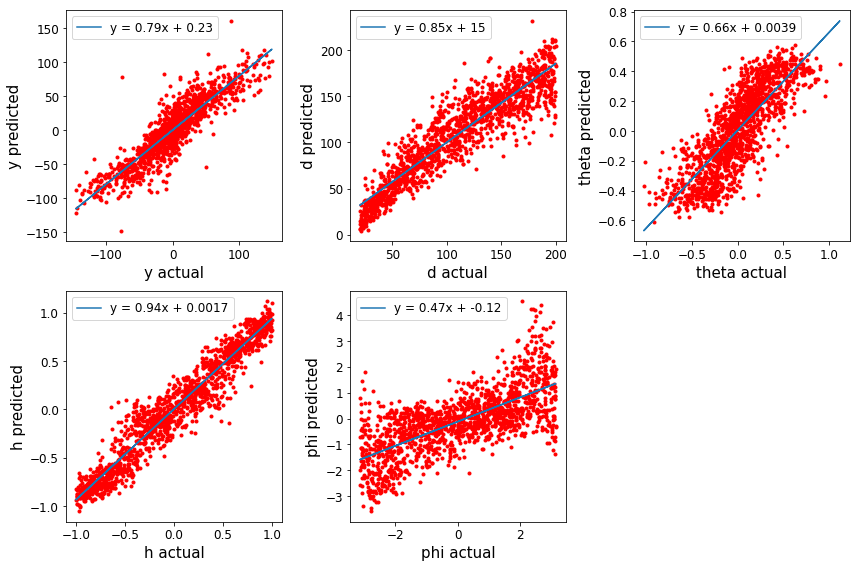

In [10]:
nlb = len(inference_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(inference_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:,i], output[:,i], c='red', marker='.')
    m, b = np.polyfit(y[:,i], output[:,i], 1)
    ax.plot(y[:,i], m * y[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

## Perform on detailed model

In [11]:
import os

DATA_PATH = 'cell_inference/resources/detailed'  # '/home/matt/data/InVivoLFPs/detailed_cell_simulation/without_basal_dendrite'
COORDS_PATH = os.path.join('cell_inference/resources', 'Electrode2D.h5')

# model_name = 'neuronal_model_496930324'
model_name = 'neuronal_model_491766131'
detailed_cells = [
    os.path.join(DATA_PATH, model_name+'_h0.0.h5'),
    os.path.join(DATA_PATH, model_name+'_h0.7071.h5'),
    os.path.join(DATA_PATH, model_name+'_h1.0.h5')
]

#### Ground truth

In [12]:
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol

loc_param = [0., 350., 80., np.pi/4, 1.0, 0.]
loc_params = np.tile(loc_param,(len(detailed_cells),1)) 
loc_params[:,4] = [0.0, 0.7071, 1.0]

labels_true = loc_params[:,[1,0,2,4,5]]
labels_true[:,1], labels_true[:,2] = cart2pol(labels_true[:,1], labels_true[:,2])

In [13]:
import h5py
from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, get_y_window, calculate_stats
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

pk_tr_idx_in_window = 24  # 24*0.025=0.6 ms
lfp_list = []
tt = []

summ_stats_test = []
bad_indices = []
yshift = []

amp_scale = 1.25
for i, sample in enumerate(detailed_cells):
    with h5py.File(sample, "r") as f:
        lfp = f['data'][:].reshape((-1, 384)) * amp_scale
        dt = f.attrs['dt']

    start, end = get_spike_window(lfp, win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(lfp[start:end,:])
    tt.append(np.arange(lfp.shape[0])[start:end] * dt)
    
    try:
        g_lfp, _, y_c = build_lfp_grid(lfp_list[i], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    summ_stats_test.append(calculate_stats(g_lfp))
    if has_yshift:
        yshift.append(y_c - labels_true[i, ys_idx])

summ_stats_test = np.array(summ_stats_test)
labels_true = np.delete(labels_true, bad_indices, axis=0)
if has_yshift:
    labels_true[:, ys_idx] = np.array(yshift)
print('%d bad samples.' % len(bad_indices))

df_la_true = pd.DataFrame(labels_true, columns=inference_list)

0 bad samples.


#### Prediction

In [14]:
device = torch.device("cpu")
model.eval()

labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# back to original scale
for i, lb in enumerate(inference_list):
    labels_pred[:,i] = org_scale(labels_pred[:,i], ranges[lb])

df_la_pred = pd.DataFrame(labels_pred, columns=inference_list)

In [15]:
df_comp = {}
for c1, c2 in zip(df_la_true.columns, df_la_pred.columns):
    df_comp[c1+' true'] = df_la_true[c1]
    df_comp[c1+' pred'] = df_la_pred[c2]
df_comp = pd.DataFrame(df_comp)

# rad to degree
rad2deg = lambda x: 180 / np.pi * x

for p in ['theta', 'h', 'phi']:
    idx = df_comp.columns.get_loc(p + ' pred') + 1
    for d in [' pred', ' true']:
        val = df_comp[p + d]
        if p == 'h':
            val = np.pi/2 - np.arccos(val)
        df_comp.insert(idx, p + d + ' (degree)', rad2deg(val))

with pd.option_context('display.float_format', '{:.4g}'.format, 'max_columns', None):
    display(df_comp)

,y true,y pred,d true,d pred,theta true,theta pred,theta true (degree),theta pred (degree),h true,h pred,h true (degree),h pred (degree),phi true,phi pred,phi true (degree),phi pred (degree)
0,0,1.446,80,73.38,0,-0.09891,0,-5.667,0,0.2682,0,15.56,0,-0.316,0,-18.11
1,-20,-25.35,80,64.88,0,0.1603,0,9.182,0.7071,0.894,45,63.39,0,-2.664,0,-152.7
2,-40,-23.76,80,76.69,0,-0.05564,0,-3.188,1,0.5947,90,36.49,0,-2.717,0,-155.7
